In [13]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import corner
import emcee
from IPython.display import display, Math
from ultranest.plot import PredictionBand

def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)
    return model

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0 

class logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(object):
    def __init__(self, x, y, yerr, lines, linesbroad, fixed, fitted, mins, maxes): 
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.linesbroad = linesbroad
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout, broadout = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return diskout,narrowout,broadout

In [7]:
z = 0.04573
cont = np.array([ 1.03658933e-13, -1.93697829e-03, -1.01611922e-13])
sub = 0.6e-16

fn = 'Files/2018hyz-E2.txt'
wl, flux = np.loadtxt(fn, unpack=True)
flux -= power_law(wl, *cont) - sub
flux *= 0.3e18

olambda = 6563
wavemin = 6100
wavemax = 7000
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)
t0 = 1e-5   # optical depth normalization (0=no wind)
eta = 0.3 #optical depth power-law index
anglam = 2 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)
amp = 0 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components
broadwidth = 80
broadHalphaflux = 16

angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 5, 30
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

broadwidthmin, broadwidthmax = 20, 500
broadHalphafluxmin, broadHalphafluxmax = 0.0, 300

diskmins = [
xi1min,xi2min,broadmin,angimin,broadwidthmin,broadHalphafluxmin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,broadwidthmax,broadHalphafluxmax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax]

NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
linesbroad = [6300]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 7
NIIbflux = 3
diskflux = 13
SIIbflux = 0

angi = 22 #disk inclination angle (degrees)
xi1 = 100 #inner disk radius (GM/c^2)
xi2 = 800 #outer disk radius (multiple of xi1)
broad = 1050 #broadening parameter (km/s)

fitted_labels = ['xi1','xi2','broad','angi','broadwidth','broadHalphaflux','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,broadwidth,broadHalphaflux,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,diskflux]
names = [r'$\xi_1$', r'$\xi_2$', r'$\sigma$', r'$i$', r'$bw$', r'$f_\text{b}$',
         r'$nf$', r'$nw_1$', r'$nw_2$', r'$\vartheta$', r'$\tau_0$', r'$\eta$',
         r'$f_\text{H}$', r'$f_\text{N}$', r'$f_\text{d}$']
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [5]:
lp = logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

In [6]:
nwalkers, ndim = (50, len(initial)) # 50 by 15
filename ='Files/emcee-2018hyz-E2.h5'
backend = emcee.backends.HDFBackend(filename, read_only=True)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp, backend=backend)
flat_samples = sampler.get_chain(discard=5000, flat=True)

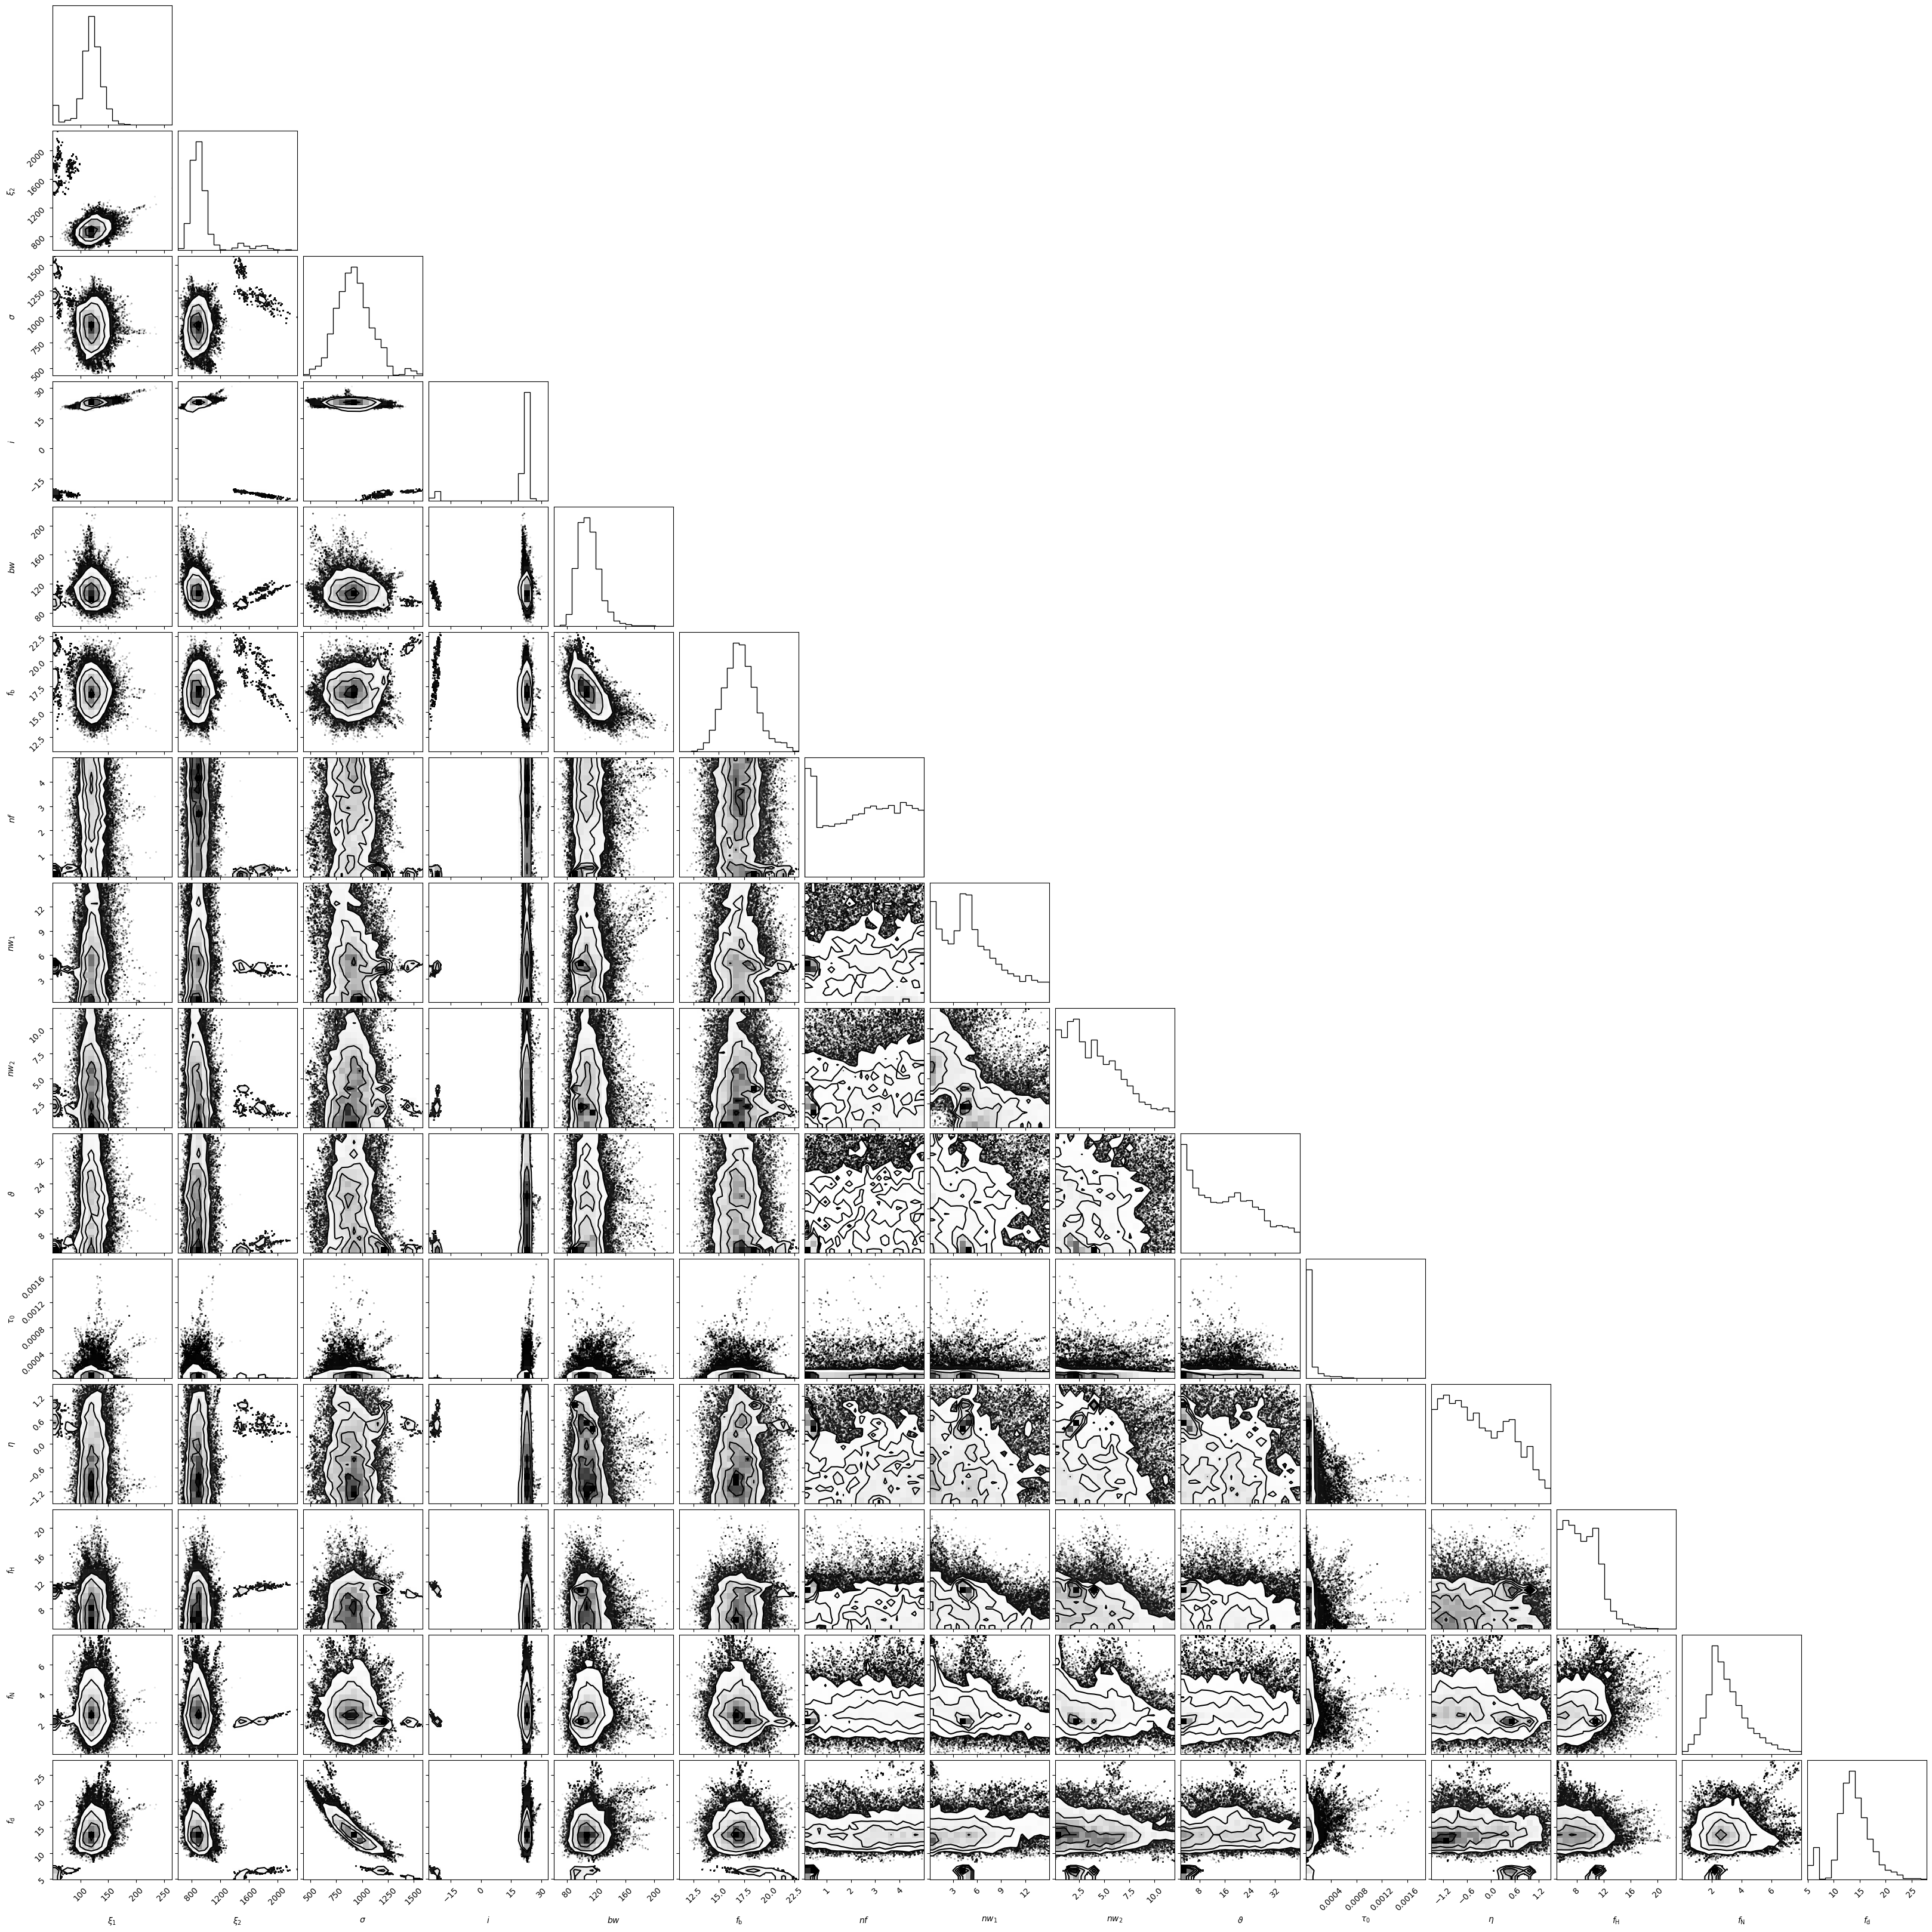

In [10]:
fig = corner.corner(flat_samples, labels=names)
plt.savefig('2020zso-corner.png')
plt.show()

<Figure size 600x600 with 0 Axes>

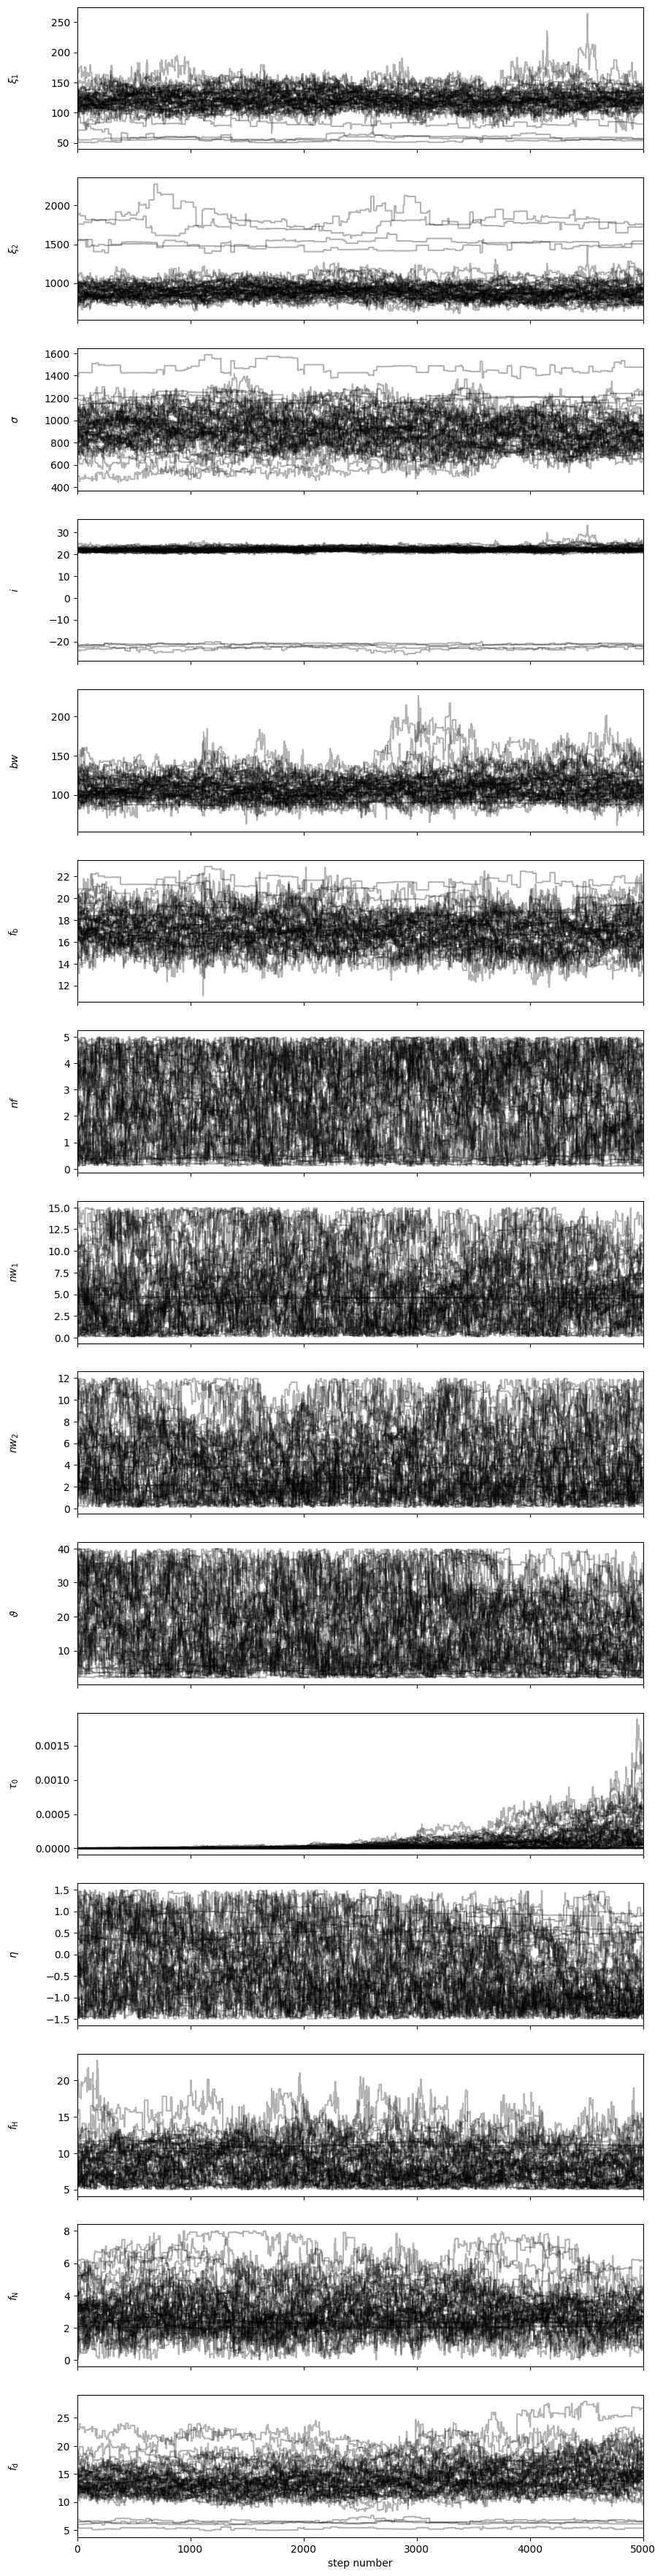

In [11]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(len(initial), figsize=(10,3*15), sharex=True)
samples = sampler.get_chain(discard=5000)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()

In [14]:
mcmc_soln = []
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))
    
    mcmc_soln.append(mcmc[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

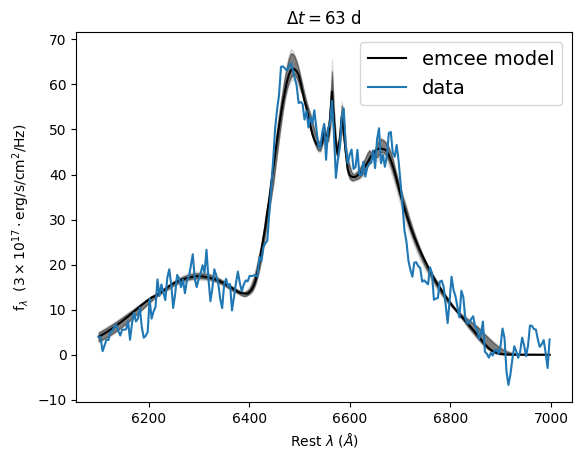

In [23]:
band = PredictionBand(wl/(1+fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    try:
        modelfit = lp.test(sample)
        band.add(modelfit)
        #plt.plot(wl/(1+fixed['z']),modelfit,alpha=0.1)
    except:
        continue
band.line(color='k',label='emcee model')
# add 1 sigma quantile
band.shade(q=0.2, color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.25, color='gray', alpha=0.2)

plt.plot(wl/(1+fixed['z']),flux,label='data')
#plt.title('Best Fit by Emcee -- AT2020zso')
plt.legend(fontsize=14)
plt.xlabel("Rest $\lambda$ ($\AA$)"); plt.ylabel(r'f$_\lambda$ ' + r' ($3\times10^{17}\cdot$erg/s/cm$^2$/Hz)')
plt.title(r'$\Delta t=63$ d')
plt.savefig('emcee-E2.png')
plt.show()